# CPSC 537 Final Project

## 1. Fetch Players, Teams, Games and Drafts Data Through NBA_API

The basketball dataset is fetched through nba_api, which is an API Client for https://www.nba.com. We saved it as basketball.sqlite under Data directory. Here is the link to this API: https://github.com/swar/nba_api.

In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [2]:
db_path = './RawData/basketball.sqlite'
connection = sqlite3.connect(db_path)
cursor = connection.cursor()
cursor.execute('SELECT name from sqlite_master where type= "table"')
table_names = [table[0] for table in cursor.fetchall()]
print(table_names)
#connection.close()

['Player', 'Team', 'Team_Attributes', 'Team_History', 'Player_Attributes', 'Game_Officials', 'Game_Inactive_Players', 'Team_Salary', 'Player_Salary', 'Draft', 'Draft_Combine', 'Player_Photos', 'Player_Bios', 'Game', 'News', 'News_Missing']


Here are 16 tables in this dataset. The names are: Player, Player_Attributes, Player_Salary, Player_Photos, Player_Bios, Team, Team_History, Team_Attributes, Team_Salary, Game, Game_Officials, Game_Inactive_Players, Draft, Draft_Combine, News, News_Missing.

## 2. Download NBA Team Annual Attendance, Historical NBA Performance Dataset From Data.World


We download NBA team annual attendance data and historical NBA performance data from https://data.world/datasets/nba. Each dataset is a separate table, which contains the statistics of team's participation and performance in each year. The original data is in .xlsx format under Data directory.

In [3]:
performance = pd.read_excel(
    './RawData/Historical NBA Performance.xlsx', 
    header=0)
attendance = pd.read_excel(
    './RawData/NBA Team Annual Attendance.xlsx', 
    header=0)

In [4]:
performance.head()

,Year,Team,Record,Winning Percentage
0,2016-17,Celtics,25-15,0.625
1,2015-16,Celtics,48-34,0.585
2,2014-15,Celtics,40-42,0.488
3,2013-14,Celtics,25-57,0.305
4,2012-13,Celtics,41-40,0.506


In [5]:
attendance.head()

,Starting Year,Rank,Team,Home: Total Games,Home: Total Attendance,Home: Avg Attendance,Home: % Capactiy,Away: Total Games,Away: Total Attendance,Away: Avg Attendance,Away: % Capactiy
0,2015.0,1.0,Bulls,41.0,894659.0,21820.0,104.3,41.0,18156.0,94.5,82.0
1,2015.0,2.0,Cavaliers,41.0,843042.0,20562.0,100.0,41.0,18910.0,98.2,82.0
2,2015.0,3.0,Mavericks,41.0,825901.0,20143.0,104.9,41.0,17727.0,93.4,82.0
3,2015.0,4.0,Raptors,41.0,812863.0,19825.0,100.1,41.0,17162.0,89.2,82.0
4,2015.0,5.0,NY Knicks,41.0,812292.0,19812.0,100.0,41.0,18440.0,96.0,82.0


## 3. Build a New Database

Here we connect all of these dataset together and build a new database.

In [6]:
db_path = './RawData/basketball.sqlite'
new_db_path = './DataBase/nba_data.sqlite'
src = sqlite3.connect(db_path)
dst = sqlite3.connect(new_db_path)

with dst:
    src.backup(dst)
    
src.close()

In [7]:
performance.to_sql('Performance', dst, if_exists='append', index=False)

/Users/chenjiawen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [8]:
attendance.to_sql('Attendance', dst, if_exists='append', index=False)

In [9]:
cursor = dst.cursor()
cursor.execute('SELECT name from sqlite_master where type= "table"')
table_names = [table[0] for table in cursor.fetchall()]
print(table_names)

['Player', 'Team', 'Team_Attributes', 'Team_History', 'Player_Attributes', 'Game_Officials', 'Game_Inactive_Players', 'Team_Salary', 'Player_Salary', 'Draft', 'Draft_Combine', 'Player_Photos', 'Player_Bios', 'Game', 'News', 'News_Missing', 'Performance', 'Attendance']


In [10]:
cursor.execute('SELECT * from Attendance')
len(cursor.fetchall())

476

In [11]:
cursor.execute('SELECT * from Performance')
len(cursor.fetchall())

1417

In [12]:
#dst.close()

From the output above, we successfully connect two dataset together. The new database named nba_data is under DataBase directory.

## 4. Player Data Analysis

Players' data is stored in 5 tables: Player, Player_Attributes, Player_Salary, Player_Photos and Player_Bios. The relationship of these tables is as follows.

![figure1](./Image/player_diagram.png)

### 4.1 Player Table

In [13]:
cursor.execute('SELECT * from Player')
cols = [column[0] for column in cursor.description]
player = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player.head()

,id,full_name,first_name,last_name,is_active
0,76001,Alaa Abdelnaby,Alaa,Abdelnaby,0
1,76002,Zaid Abdul-Aziz,Zaid,Abdul-Aziz,0
2,76003,Kareem Abdul-Jabbar,Kareem,Abdul-Jabbar,0
3,51,Mahmoud Abdul-Rauf,Mahmoud,Abdul-Rauf,0
4,1505,Tariq Abdul-Wahad,Tariq,Abdul-Wahad,0


In [14]:
player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4501 entries, 0 to 4500
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4501 non-null   object
 1   full_name   4501 non-null   object
 2   first_name  4501 non-null   object
 3   last_name   4501 non-null   object
 4   is_active   4501 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 175.9+ KB


Player Table has 4500 rows and 5 columns. This table contains players' id, full name, first name, last name and the information on whether the player is active. We use the key word "GROUP BY" to group all of players by the is_active variable to see how many active and inactive players there are.

In [15]:
cursor.execute('SELECT is_active, count(*) as count from Player GROUP BY is_active;')
cols = [column[0] for column in cursor.description]
active_info = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
active_info

,is_active,count
0,0,3982
1,1,519


From the output above, we can find there are 3982 inactive players and 519 active players.

### 4.2 Player_Attributes Table

In [16]:
cursor.execute('SELECT * from Player_Attributes')
cols = [column[0] for column in cursor.description]
player_attributes = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player_attributes.head()

,ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,...,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,AST,REB,ALL_STAR_APPEARANCES,PIE
0,76001,Alaa,Abdelnaby,Alaa Abdelnaby,"Abdelnaby, Alaa",A. Abdelnaby,alaa-abdelnaby,1968-06-24T00:00:00,Duke,USA,...,Y,Y,1990,1,25,5.7,0.3,3.3,0.0,NaN
1,76002,Zaid,Abdul-Aziz,Zaid Abdul-Aziz,"Abdul-Aziz, Zaid",Z. Abdul-Aziz,zaid-abdul-aziz,1946-04-07T00:00:00,Iowa State,USA,...,Y,Y,1968,1,5,9.0,1.2,8.0,0.0,NaN
2,76003,Kareem,Abdul-Jabbar,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",K. Abdul-Jabbar,kareem-abdul-jabbar,1947-04-16T00:00:00,UCLA,USA,...,Y,Y,1969,1,1,24.6,3.6,11.2,18.0,NaN
3,51,Mahmoud,Abdul-Rauf,Mahmoud Abdul-Rauf,"Abdul-Rauf, Mahmoud",M. Abdul-Rauf,mahmoud-abdul-rauf,1969-03-09T00:00:00,Louisiana State,USA,...,Y,Y,1990,1,3,14.6,3.5,1.9,0.0,NaN
4,1505,Tariq,Abdul-Wahad,Tariq Abdul-Wahad,"Abdul-Wahad, Tariq",T. Abdul-Wahad,tariq-abdul-wahad,1974-11-03T00:00:00,San Jose State,France,...,Y,Y,1997,1,11,7.8,1.1,3.3,0.0,NaN


In [17]:
player_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                4500 non-null   object 
 1   FIRST_NAME                        4500 non-null   object 
 2   LAST_NAME                         4500 non-null   object 
 3   DISPLAY_FIRST_LAST                4500 non-null   object 
 4   DISPLAY_LAST_COMMA_FIRST          4500 non-null   object 
 5   DISPLAY_FI_LAST                   4500 non-null   object 
 6   PLAYER_SLUG                       4500 non-null   object 
 7   BIRTHDATE                         4500 non-null   object 
 8   SCHOOL                            4497 non-null   object 
 9   COUNTRY                           4500 non-null   object 
 10  LAST_AFFILIATION                  4500 non-null   object 
 11  HEIGHT                            4403 non-null   float64
 12  WEIGHT

The Player Attribute table has 4500 rows and 37 columns. Each row is for a distinct player and the columns include the player's id, name, birthdate, school, team, etc.

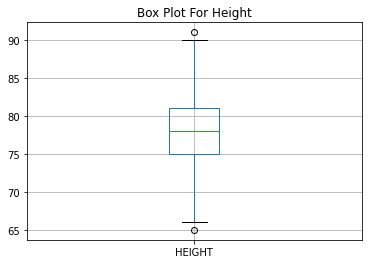

In [18]:
import matplotlib.pyplot as plt

plt.figure()
player_attributes.boxplot(["HEIGHT"])
plt.title("Box Plot For Height")
plt.show()

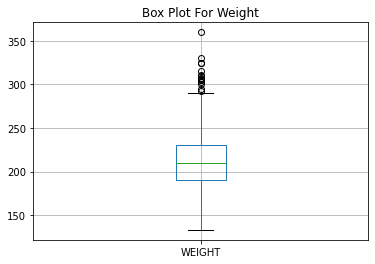

In [19]:
plt.figure()
player_attributes.boxplot(["WEIGHT"])
plt.title("Box Plot For Weight")
plt.show()

The players' average height is around 78 inches and average weight is around 210 pounds.

In [20]:
cursor.execute('SELECT Team_id, Team_name, count(*) as Count from Player_Attributes GROUP BY Team_name ORDER BY Count DESC;')
cols = [column[0] for column in cursor.description]
team_info1 = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_info1.head()

,TEAM_ID,TEAM_NAME,Count
0,0,,664
1,1610612744,Warriors,216
2,1610612752,Knicks,203
3,1610612765,Pistons,202
4,1610612737,Hawks,201


In [21]:
cursor.execute('SELECT Team_id, Team_name, count(*) as Count from Player_Attributes GROUP BY Team_name ORDER BY Count ASC;')
cols = [column[0] for column in cursor.description]
team_info2 = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_info2.head()

,TEAM_ID,TEAM_NAME,Count
0,1610612764,Zephyrs,6
1,1610612737,Blackhawks,10
2,1610610026,Rebels,10
3,1610612764,Packers,11
4,1610610028,Falcons,12


There are 664 players who don't belong to any team, or the team information is missing. Apart from this, we order the table by the number of each team's members. We find the team named Warriors has the maximum number of members while Zephyrs has the minimum number.

### 4.3 Player_Salary Table

In [22]:
cursor.execute('SELECT * from Player_Salary')
cols = [column[0] for column in cursor.description]
player_salary = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player_salary.head()

,slugSeason,nameTeam,namePlayer,statusPlayer,isFinalSeason,isWaived,isOnRoster,isNonGuaranteed,isTeamOption,isPlayerOption,typeContractDetail,value
0,2020-21,Atlanta Hawks,Bogdan Bogdanovic,current roster,0,0,1,0,0,0,Guaranteed,18000000.0
1,2021-22,Atlanta Hawks,Bogdan Bogdanovic,current roster,0,0,1,0,0,0,Guaranteed,18000000.0
2,2022-23,Atlanta Hawks,Bogdan Bogdanovic,current roster,0,0,1,0,0,0,Guaranteed,18000000.0
3,2023-24,Atlanta Hawks,Bogdan Bogdanovic,current roster,1,0,1,0,0,1,Player Option,18000000.0
4,2020-21,Atlanta Hawks,Brandon Goodwin,current roster,0,0,1,0,0,0,Guaranteed,1701593.0


In [23]:
player_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   slugSeason          1292 non-null   object 
 1   nameTeam            1292 non-null   object 
 2   namePlayer          1292 non-null   object 
 3   statusPlayer        1292 non-null   object 
 4   isFinalSeason       1292 non-null   int64  
 5   isWaived            1292 non-null   int64  
 6   isOnRoster          1292 non-null   int64  
 7   isNonGuaranteed     1292 non-null   int64  
 8   isTeamOption        1292 non-null   int64  
 9   isPlayerOption      1292 non-null   int64  
 10  typeContractDetail  1292 non-null   object 
 11  value               1292 non-null   float64
dtypes: float64(1), int64(6), object(5)
memory usage: 121.2+ KB


This table has 1292 rows and 12 columns. Then we draw a histogram to find the distribution of player's salary.

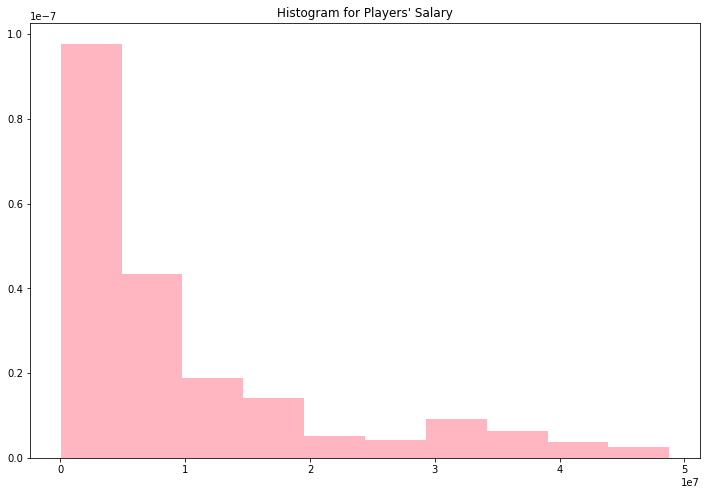

In [24]:
player_salary.dropna(axis=0)
plt.figure(figsize=(12,8))
plt.hist(x=player_salary['value'], color="lightpink", density=True)
plt.title("Histogram for Players' Salary")
plt.show()

In [25]:
print(max(player_salary['value']), min(player_salary['value']))

48787676.0 25000.0


The distribution of players' salary is highly right skewed. Only a very small number of players can get high salaries. The maximum salary is 48787676 dollars and the minimum salary is 25000 dollars.

### 4.4 Player_Photos Table

In [26]:
cursor.execute('SELECT * from Player_Photos')
cols = [column[0] for column in cursor.description]
player_photos = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player_photos.head()

,isActive,isRookie,namePlayer,idPlayer,countSeasons,yearSeasonFirst,yearSeasonLast,idTeam,hasGamesPlayedFlag,urlPlayerStats,urlPlayerThumbnail,urlPlayerHeadshot,urlPlayerActionPhoto,hasHeadShot,hasThumbnail,hasAction,urlPlayerPhoto
0,0,0,Alaa Abdelnaby,76001.0,4.0,1990.0,1994.0,NaN,0,https://stats.nba.com/player/76001,https://stats.nba.com/media/players/230x185/76...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/76001.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/76...
1,0,0,Zaid Abdul-Aziz,76002.0,9.0,1968.0,1977.0,NaN,0,https://stats.nba.com/player/76002,https://stats.nba.com/media/players/230x185/76...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/76002.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/76...
2,0,0,Kareem Abdul-Jabbar,76003.0,19.0,1969.0,1988.0,NaN,0,https://stats.nba.com/player/76003,https://stats.nba.com/media/players/230x185/76...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/76003.png,1.0,1.0,1.0,https://ak-static.cms.nba.com/wp-content/uploa...
3,0,0,Mahmoud Abdul-Rauf,51.0,10.0,1990.0,2000.0,NaN,0,https://stats.nba.com/player/51,https://stats.nba.com/media/players/230x185/51...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/51.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/51...
4,0,0,Tariq Abdul-Wahad,1505.0,6.0,1997.0,2003.0,NaN,0,https://stats.nba.com/player/1505,https://stats.nba.com/media/players/230x185/15...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/1505.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/15...


In [27]:
player_photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4593 entries, 0 to 4592
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isActive              4593 non-null   int64  
 1   isRookie              4593 non-null   int64  
 2   namePlayer            4593 non-null   object 
 3   idPlayer              4593 non-null   float64
 4   countSeasons          4593 non-null   float64
 5   yearSeasonFirst       4593 non-null   float64
 6   yearSeasonLast        4593 non-null   float64
 7   idTeam                491 non-null    float64
 8   hasGamesPlayedFlag    4593 non-null   int64  
 9   urlPlayerStats        4593 non-null   object 
 10  urlPlayerThumbnail    4593 non-null   object 
 11  urlPlayerHeadshot     4593 non-null   object 
 12  urlPlayerActionPhoto  4593 non-null   object 
 13  hasHeadShot           4378 non-null   float64
 14  hasThumbnail          4378 non-null   float64
 15  hasAction            

This table has 4593 rows and 17 columns. Each row contains one player and the public link to his photo.

### 4.5 Player_Bios Table

In [28]:
cursor.execute('SELECT * from Player_Bios')
cols = [column[0] for column in cursor.description]
player_bios = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player_bios.head()

,namePlayerBREF,urlPlayerBioBREF,nameTable,urlPlayerImageBREF,slugPlayerBREF,numberTransactionPlayer,dateTransaction,descriptionTransaction,isGLeagueMovement,isDraft,...,yearsExperience,nameTwitter,yearHighSchool,rankHighSchool,dateDeath,high schools,descriptionRelatives,descriptionHOF,playerNicknames,colleges
0,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,1.0,5647.0,Drafted by the Los Angeles Lakers in the 1st r...,0.0,1.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None
1,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,2.0,8602.0,Released by the Los Angeles Lakers.,0.0,0.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None
2,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,3.0,8671.0,Signed as an unrestricted free agent with the ...,0.0,0.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None
3,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,4.0,9856.0,"Traded by the Phoenix Suns with Sam Cassell, M...",0.0,0.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None
4,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,5.0,10835.0,Traded by the Dallas Mavericks to the Los Ange...,0.0,0.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None


In [29]:
player_bios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42749 entries, 0 to 42748
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   namePlayerBREF           42749 non-null  object 
 1   urlPlayerBioBREF         42749 non-null  object 
 2   nameTable                42749 non-null  object 
 3   urlPlayerImageBREF       28285 non-null  object 
 4   slugPlayerBREF           42749 non-null  object 
 5   numberTransactionPlayer  26970 non-null  float64
 6   dateTransaction          26962 non-null  float64
 7   descriptionTransaction   26970 non-null  object 
 8   isGLeagueMovement        26970 non-null  float64
 9   isDraft                  26970 non-null  float64
 10  isSigned                 26970 non-null  float64
 11  isWaived                 26970 non-null  float64
 12  isTraded                 26970 non-null  float64
 13  slugSeason               15602 non-null  object 
 14  nameTeam              

The Player_Bios table is similar to Player_Attributes table, but has more detailed information. For example, Player_Attributes table only show the college name for each player, but the Player_Bios table has the college name, high school name, high school year, etc. The Player_Bios table has 42749 rows and 40 columns.

In [30]:
cursor.execute('SELECT numberTransactionPlayer, count(*) as count from Player_Bios GROUP BY numberTransactionPlayer ORDER BY Count DESC;')
cols = [column[0] for column in cursor.description]
transaction_info = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
transaction_info.head()

,numberTransactionPlayer,count
0,NaN,15779
1,1.0,4010
2,2.0,3541
3,3.0,3028
4,4.0,2612


The majority of players does not have a transaction. 67.8% of players have less than 5 transactions.

## 5. Team Data Analysis

Teams' data is stored in 4 tables: Team, Team_History, Team_Attributes, Team_Salary.

### 5.1 Team Table

In [31]:
query = 'SELECT * from Team'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team.head()

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [32]:
team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30 non-null     object
 1   full_name     30 non-null     object
 2   abbreviation  30 non-null     object
 3   nickname      30 non-null     object
 4   city          30 non-null     object
 5   state         30 non-null     object
 6   year_founded  30 non-null     int64 
dtypes: int64(1), object(6)
memory usage: 1.8+ KB


There are 30 distinct teams in this table. Each row of this table contains the id, full name, abbreviation, nickname, city, state, founded year for the team.

In [33]:
query = \
    """
    SELECT id, full_name, abbreviation, year_founded, (2022 - year_founded) as age
    FROM Team
    ORDER BY age DESC
    """
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_age = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_age.head()

,id,full_name,abbreviation,year_founded,age
0,1610612738,Boston Celtics,BOS,1946,76
1,1610612744,Golden State Warriors,GSW,1946,76
2,1610612752,New York Knicks,NYK,1946,76
3,1610612747,Los Angeles Lakers,LAL,1948,74
4,1610612758,Sacramento Kings,SAC,1948,74


In [34]:
query = \
    """
    SELECT id, full_name, abbreviation, year_founded, (2022 - year_founded) as age
    FROM Team
    ORDER BY age ASC
    """
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_age = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_age.head()

,id,full_name,abbreviation,year_founded,age
0,1610612740,New Orleans Pelicans,NOP,2002,20
1,1610612761,Toronto Raptors,TOR,1995,27
2,1610612763,Memphis Grizzlies,MEM,1995,27
3,1610612750,Minnesota Timberwolves,MIN,1989,33
4,1610612753,Orlando Magic,ORL,1989,33


Boston Celtics, Golden State Warriors and New York Knicks are the three oldest NBA teams. New Orleans Pelicans is the youngest team, which is founded in 2022.

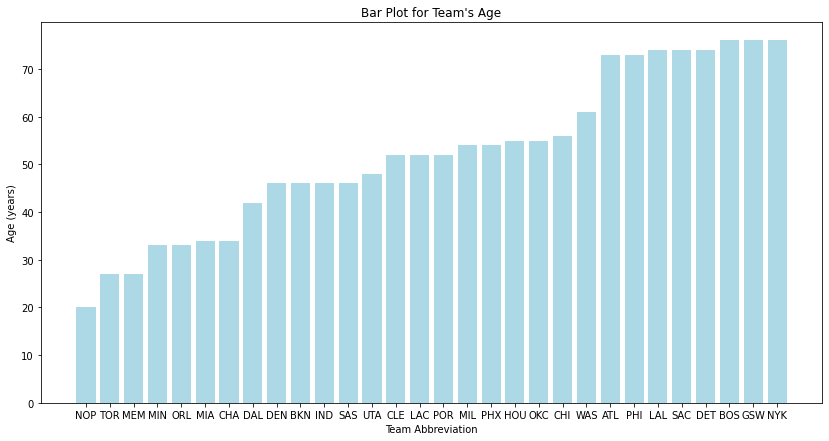

In [35]:
plt.figure(figsize= (14,7))
plt.bar(x=team_age["abbreviation"], height=team_age["age"], color="lightblue")
plt.xlabel("Team Abbreviation")
plt.ylabel("Age (years)")
plt.title("Bar Plot for Team's Age")
plt.show()

### 5.2 Team History Table

In [36]:
query = 'SELECT * from Team_History'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_history = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_history.head()

,ID,CITY,NICKNAME,YEARFOUNDED,YEARACTIVETILL
0,1610612737,Atlanta,Hawks,1968,2019
1,1610612737,St. Louis,Hawks,1955,1967
2,1610612737,Milwaukee,Hawks,1951,1954
3,1610612737,Tri-Cities,Blackhawks,1949,1950
4,1610612738,Boston,Celtics,1946,2019


In [37]:
team_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              60 non-null     object
 1   CITY            60 non-null     object
 2   NICKNAME        60 non-null     object
 3   YEARFOUNDED     60 non-null     object
 4   YEARACTIVETILL  60 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB


This table has 60 rows and 5 columns, showing each team's id, city, nickname, founded year and the active year.

In [38]:
query = 'SELECT distinct(city) from Team_History'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_city = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              60 non-null     object
 1   CITY            60 non-null     object
 2   NICKNAME        60 non-null     object
 3   YEARFOUNDED     60 non-null     object
 4   YEARACTIVETILL  60 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB


We use "distinct" key word to check whether there are two teams founded in the same city. The result shows that we have 60 distinct cities, which means each team is founded in a different city.

### 5.3 Team Attributes Table

In [39]:
query = 'SELECT * from Team_Attributes'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_attributes = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_attributes.head()

,ID,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION,FACEBOOK_WEBSITE_LINK,INSTAGRAM_WEBSITE_LINK,TWITTER_WEBSITE_LINK
0,1610612737,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Nate McMillan,Erie Bayhawks,https://www.facebook.com/hawks,https://instagram.com/atlhawks,https://twitter.com/ATLHawks
1,1610612738,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws,https://www.facebook.com/bostonceltics,https://instagram.com/celtics,https://twitter.com/celtics
2,1610612739,CLE,Cavaliers,1970,Cleveland,Rocket Mortgage FieldHouse,20562.0,Dan Gilbert,Koby Altman,JB Bickerstaff,Canton Charge,https://www.facebook.com/Cavs,https://instagram.com/cavs,https://twitter.com/cavs
3,1610612740,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Stan Van Gundy,No Affiliate,https://www.facebook.com/PelicansNBA,https://instagram.com/pelicansnba,https://twitter.com/PelicansNBA
4,1610612741,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Arturas Karnisovas,Billy Donovan,Windy City Bulls,https://www.facebook.com/chicagobulls,https://instagram.com/chicagobulls,https://twitter.com/chicagobulls


In [40]:
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      30 non-null     object 
 1   ABBREVIATION            30 non-null     object 
 2   NICKNAME                30 non-null     object 
 3   YEARFOUNDED             30 non-null     object 
 4   CITY                    30 non-null     object 
 5   ARENA                   30 non-null     object 
 6   ARENACAPACITY           20 non-null     float64
 7   OWNER                   30 non-null     object 
 8   GENERALMANAGER          30 non-null     object 
 9   HEADCOACH               30 non-null     object 
 10  DLEAGUEAFFILIATION      30 non-null     object 
 11  FACEBOOK_WEBSITE_LINK   30 non-null     object 
 12  INSTAGRAM_WEBSITE_LINK  30 non-null     object 
 13  TWITTER_WEBSITE_LINK    30 non-null     object 
dtypes: float64(1), object(13)
memory usage: 3.4+

This table has 30 rows and 14 columns. The column contains information including the name, city, arena, owner, and some public website links.

In [41]:
query = \
    '''
    SELECT ARENACAPACITY from Team_Attributes 
    WHERE "ARENACAPACITY" != 0;
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
capacity = [i[0] for i in cursor.fetchall()]
print("Minimum arena capacity:", min(capacity), "\nMaximum arena capacity:", max(capacity))

Minimum arena capacity: 17500.0 
Maximum arena capacity: 21711.0


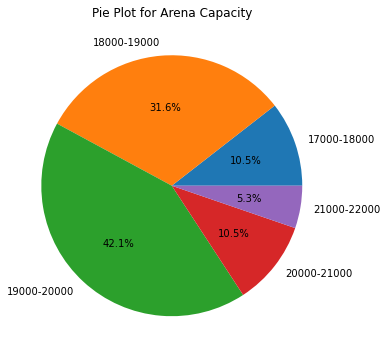

In [42]:
capacity_labels = ["17000-18000", "18000-19000", "19000-20000", "20000-21000", "21000-22000"]
capacity_counts = [0]*5
for cp in capacity:
    if cp < 18000:
        capacity_counts[0] += 1
    elif cp < 19000:
        capacity_counts[1] += 1
    elif cp < 20000:
        capacity_counts[2] += 1
    elif cp < 21000:
        capacity_counts[3] += 1
    else:
        capacity_counts[4] += 1
plt.figure(figsize=(6,6))
plt.pie(x=capacity_counts, labels=capacity_labels, autopct='%1.1f%%')
plt.title("Pie Plot for Arena Capacity")
plt.show()

We draw a pie plot for arena's capacity. The maximum capacity is 21711 while the minimum is 17500. Around 42.1% of arenas have a capacity between 19000 and 20000.

### 5.4 Team Salary Table

In [43]:
query = 'SELECT * from Team_Salary'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_salary = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_salary.head()

,nameTeam,slugTeam,urlTeamSalaryHoopsHype,X2020-21,X2021-22,X2022-23,X2023-24,X2024-25,X2025-26
0,Atlanta Hawks,ATL,http://hoopshype.com/salaries/atlanta_hawks/,118647039.0,95496087.0,59656896.0,18000000.0,0.0,0.0
1,Boston Celtics,BOS,http://hoopshype.com/salaries/boston_celtics/,132032864.0,132077647.0,95626895.0,62027548.0,34844000.0,37092000.0
2,Brooklyn Nets,BKN,http://hoopshype.com/salaries/brooklyn_nets/,168854452.0,165982367.0,157168219.0,19928571.0,0.0,0.0
3,Charlotte Hornets,CHA,http://hoopshype.com/salaries/charlotte_hornets/,108218809.0,83125939.0,44614401.0,31500000.0,0.0,0.0
4,Chicago Bulls,CHI,http://hoopshype.com/salaries/chicago_bulls/,128963580.0,96304124.0,22000000.0,0.0,0.0,0.0


In [44]:
team_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nameTeam                30 non-null     object 
 1   slugTeam                30 non-null     object 
 2   urlTeamSalaryHoopsHype  30 non-null     object 
 3   X2020-21                30 non-null     float64
 4   X2021-22                30 non-null     float64
 5   X2022-23                30 non-null     float64
 6   X2023-24                30 non-null     float64
 7   X2024-25                30 non-null     float64
 8   X2025-26                30 non-null     float64
dtypes: float64(6), object(3)
memory usage: 2.2+ KB


This table has 30 rows and 9 columns. The columns show annual salary from 2020 to 2025 (expected). 